# **1. Import Data and Library**

In [1]:
import numpy as np
import pandas as pd
import re
import emoji
import seaborn as sns

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_excel('/kaggle/input/twitter-dataset-for-sentiment-analysis/LabeledText.xlsx')
data

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive
...,...,...,...
4864,995.txt,OMG. Well done #Eskom! 'Man dies during #LoadS...,positive
4865,996.txt,Feelin' the love in here! #ValentinesDay #caring,positive
4866,997.txt,#blue #eyes can't be #beaten,neutral
4867,998.txt,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,neutral


# **2. Checking Data**

In [2]:
data.isnull().sum()

File Name    0
Caption      0
LABEL        0
dtype: int64

In [3]:
sentiment = data.LABEL.value_counts()
sentiment

neutral     1771
positive    1646
negative    1452
Name: LABEL, dtype: int64

# **3. Cleaning Data**

In [4]:
def cleanTweets(text):
    text = re.sub('[^a-zA-Z]', ' ', str(text).lower().strip())
    text = re.sub('@[A-Za-z0-9_]+', '', text) 
    text = re.sub('#','',text) 
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    text = emoji.replace_emoji(text, replace='')
    return text
data['cleanedTweet'] = data['Caption'].apply(cleanTweets) 
data

,File Name,Caption,LABEL,cleanedTweet
0,1.txt,How I feel today #legday #jelly #aching #gym,negative,how i feel today legday jelly aching gym
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative,arrivatw absolute disgrace two carriages from...
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive,this is my valentine s from of my nephews i...
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral,betterfeelingfilms rt via instagram first da...
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive,zoe s first love rattled johnnyharper
...,...,...,...,...
4864,995.txt,OMG. Well done #Eskom! 'Man dies during #LoadS...,positive,omg well done eskom man dies during loads...
4865,996.txt,Feelin' the love in here! #ValentinesDay #caring,positive,feelin the love in here valentinesday caring
4866,997.txt,#blue #eyes can't be #beaten,neutral,blue eyes can t be beaten
4867,998.txt,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,neutral,la chucha louuu te chupo los ojos


# **4. Lemmatization and Stopwords**

In [5]:
def text_preprocessing(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)
data['cleanedTweet'] = data['cleanedTweet'].apply(text_preprocessing)
data

,File Name,Caption,LABEL,cleanedTweet
0,1.txt,How I feel today #legday #jelly #aching #gym,negative,feel today legday jelly ache gym
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative,arrivatw absolute disgrace carriage bangor h...
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive,valentine s nephew elated little thing ...
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral,betterfeelingfilm rt instagram day film ...
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive,zoe s love rattle johnnyharper
...,...,...,...,...
4864,995.txt,OMG. Well done #Eskom! 'Man dies during #LoadS...,positive,omg eskom man die loadshedde power...
4865,996.txt,Feelin' the love in here! #ValentinesDay #caring,positive,feelin love valentinesday care
4866,997.txt,#blue #eyes can't be #beaten,neutral,blue eye t beat
4867,998.txt,LA CHUCHA LOUUU TE CHUPO LOS OJOS..!,neutral,la chucha louuu te chupo los ojos


In [6]:
print(data.iloc[1002, 3])
print(data.iloc[1002, 1])

                             reedit iron man     bleed e           
Í»îËÙˆó¡¡¤¢¤ß¤¢¤ß¡¡¥×¥ì‚Ž¡¡REEDIT IRON MAN 01 Bleeding E... #¤Þ¤È¤á 


# **5. Split Dataset**

In [7]:
X = data['cleanedTweet']
y = data['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,shuffle=True,stratify=y)

# **6. Create Model Using MultinomialNB**

In [8]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [9]:
model = MultinomialNB()
model.fit(X_train,y_train)
model.score(X_train,y_train)

0.9681643132220796

# **7. Result**

In [10]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.6765913757700205


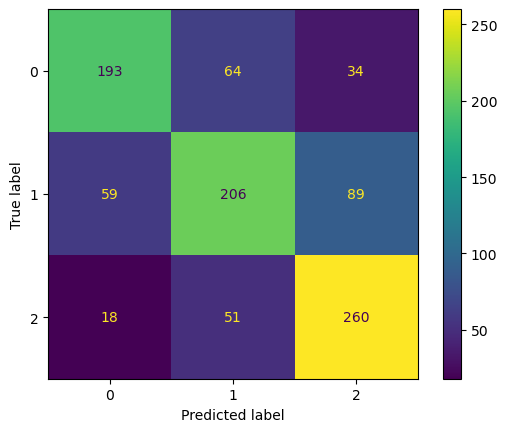

In [11]:
cf = confusion_matrix(y_test, y_pred)
plotcf = ConfusionMatrixDisplay(cf)
plotcf.plot()

In [12]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

    negative       0.71      0.66      0.69       291
     neutral       0.64      0.58      0.61       354
    positive       0.68      0.79      0.73       329

    accuracy                           0.68       974
   macro avg       0.68      0.68      0.68       974
weighted avg       0.68      0.68      0.67       974

